# Basic GP optimizer - clean mutinormal example

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated')
saveResultsQ = False

failed to import parallelstuff


### Creat the machine interface

In [2]:
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [0.25,0.25]  # use H1 = H2 = 25 as default start, following Cameron's setup
#min-max range

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1

In [3]:
mi.x

array([[0.25, 0.25]])

In [4]:
#check the reading objective is working
mi.getState()

(array([[0.25, 0.25]]), array([[87875.41815968]]))

In [13]:
#check noise std
y = [mi.getState()[1][0] for x in range(100)]
np.std(y)

outscope.txt


KeyboardInterrupt: 

### Create the gp

In [7]:
gp_ls = np.array(np.ones(ndim))
gp_amp = 10 # default = 1
gp_noise = 0.01  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

### Create the BO

In [8]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f5d4127d240>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
/home/cz489/STEMalign_BO/outscope.txt
simulation finished
x_init [[0.25 0.25]]
y_init [[17.68985927]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [9]:
Obj_state_s=[]

iteration = 19
/home/cz489/STEMalign_BO/outscope.txt
simulation finished
current position: [[0.25 0.25]] current objective value: [17.68985927]


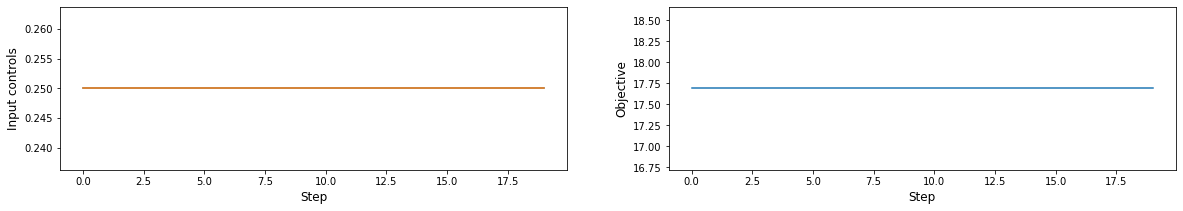

[0.25 0.25]
[0.25 0.25]
[[0.25 0.25]]
/home/cz489/STEMalign_BO/outscope.txt
simulation finished


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
Niter = 20
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
   
    Obj_state_s.append(mi.getState()[1][0])
    print ('current position:', mi.x, 'current objective value:', Obj_state_s[-0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Input controls',fontsize=12)
    ax.set_xlabel('Step',fontsize=12)    
    ax.plot(opt.X_obs)
    ax2.set_ylabel('Objective',fontsize=12)
    ax2.set_xlabel('Step',fontsize=12)
    ax2.plot(Obj_state_s)
    plt.show(); 
    
    opt.OptIter()

In [19]:
opt.model.predict(np.array([0,0],ndmin=2))

(array([[17.68510877]]), array([[0.00020504]]))

In [20]:
#save results if desired
from datetime import datetime
import time
def saveResults(filename):
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results/multinormal')
    except: pass
    results = {}
    results['start_point'] = start_point
    results['hyps'] = [gp_precisionmat,gp_amp, gp_noise]
    results['offset'] = offset
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/multinormal/scan_'+timestr+'_'+filename, results)
    print('saved to:  saved_results/GPT/  scan_'+timestr+'_'+filename)

In [21]:
saveResults('exmple1')

NameError: name 'offset' is not defined

## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.

In [14]:
# 1D scan along hex1 = hex2
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-100,100,num=52)
emit_list = []

for i in range(len(hex_list)):
    start_point = [50,hex_list[i]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_list.append(mi.getState()[1][0])
    print(hex_list[i], emit_list[-1])

-100.0 [10057754.24634836]
-96.07843137254902 [6784207.5359999]
-92.15686274509804 [5563775.94832864]
-88.23529411764706 [5020582.76671388]
-84.31372549019608 [3711545.47309515]
-80.3921568627451 [3082362.49611698]
-76.47058823529412 [2608480.66740436]
-72.54901960784314 [1888329.76837172]
-68.62745098039215 [1345824.75077223]
-64.70588235294119 [924225.45368338]
-60.7843137254902 [6805745.76715062]
-56.86274509803922 [1808363.41294161]
-52.94117647058824 [642190.68875458]
-49.01960784313726 [129766.2615505]
-45.09803921568628 [1383238.23470687]
-41.1764705882353 [4431737.51509073]
-37.254901960784316 [3941148.98882435]
-33.33333333333334 [1083253.67510074]
-29.411764705882362 [1357474.59295565]
-25.49019607843138 [1780195.10713758]
-21.5686274509804 [3125991.61966896]
-17.64705882352942 [3682921.95066087]
-13.72549019607844 [4468442.67506302]
-9.803921568627459 [5343001.63304713]
-5.882352941176478 [7430066.77781205]
-1.9607843137254974 [7905410.08266719]
1.9607843137254832 [9190045.7

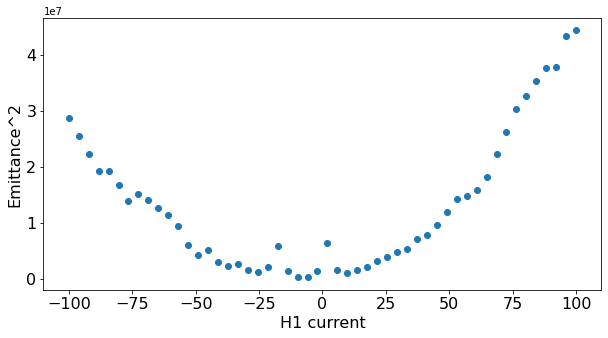

In [19]:
hex_list = np.load('hex_list_h2=-100_100_h2=8.npy')
emit_list = np.load('emit_list_h2=-100_100_h2=8.npy')

fig = plt.figure(figsize = [10,5])
plt.scatter(hex_list, np.asarray(emit_list))
plt.ylabel('Emittance^2',fontsize = 16)
plt.xlabel('H1 current',fontsize  = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('hex_scan_h1=-100_100_h2=8.png')

# np.save('emit_list_h2=-100_100_h1=50.npy',np.asarray(emit_list))
# np.save('hex_list_h2=-100_100_h1=50.npy',hex_list)

44.0 -100.0 12059988.672165059


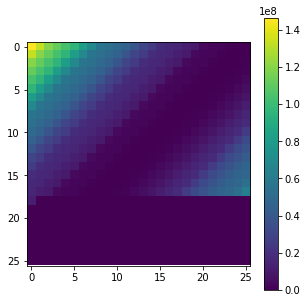

In [ ]:
# 2D parameter scan for all (hex1, hex2) pairs
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-100,100,num=26)
emit_matrix = np.zeros([26,26])

for i in range(len(hex_list)):
    for j in range(len(hex_list)):
        imgname = '/home/cz489/STEMalign_BO/SimulationResults/ronchigram_'+ str(i)+'_'+str(j)+'.npy'
        txtname = '/home/cz489/STEMalign_BO/SimulationResults/outscope_'+ str(i)+'_'+str(j)+'.txt'
        if os.path.exists(txtname):
            emit_matrix[i,j] = calcEmittance(txtname)
        else:
            start_point = [hex_list[i],hex_list[j]]  # use H1 = H2 = 25 as default start, following Cameron's setup
            mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
            mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
            emit_matrix[i,j] = mi.getState()[1][0]
            
            os.rename("/home/cz489/STEMalign_BO/outscope.txt", txtname)
            os.rename("/home/cz489/STEMalign_BO/ronchigram.npy", imgname)
        
        clear_output(wait=True)
        print(hex_list[i], hex_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix)
        plt.colorbar()
        plt.show()


            

In [3]:
start_point = [36,-44]  # use H1 = H2 = 25 as default start, following Cameron's setup
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
print(mi.getState())

(array([[ 36, -44]]), array([[3297512.23044574]]))


/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
def calcEmittance(ASCIIFILE):
    screen =  np.loadtxt(ASCIIFILE, skiprows=5)
    N = 24
    maxsig = 1
    MConHBAR  =  2.59e12
    x_grid, y_grid = np.meshgrid(np.linspace(-N/2, N/2, N),
                             np.linspace(-N/2, N/2, N))
    temp = x_grid * x_grid + y_grid * y_grid
    mask =temp < N*N/4

    x  = screen[:,0]
    y  = screen[:,1]
    kx = MConHBAR*screen[:,4]*screen[:,7]
    ky = MConHBAR*screen[:,5]*screen[:,7]

    meanx = np.mean(x)
    sigx  = np.std(x)

    meany = np.mean(y)
    sigy  = np.std(y)

    kx_bins = [[[] for n in range(0,N)] for m in range(0,N)]
    ky_bins = [[[] for n in range(0,N)] for m in range(0,N)]

    kx_grid = np.zeros([N, N])
    ky_grid = np.zeros([N, N])

    x_grid, y_grid = np.meshgrid(sigx*np.linspace(-maxsig, maxsig, N),
                                 sigy*np.linspace(-maxsig, maxsig, N))

    for xi, yi, kxi, kyi in zip(x, y, kx, ky):
        i = int(0.5*N*((yi-meany)/(maxsig*sigy)) + 0.5*N)
        j = int(0.5*N*((xi-meanx)/(maxsig*sigx)) + 0.5*N)
        if i < 0 or i > N-1 or j < 0 or j > N-1:
            continue
        kx_bins[i][j].append(kxi)
        ky_bins[i][j].append(kyi)

    for i in range(0, N):
        for j in range(0, N):
            kx_grid[i,j] = np.mean(kx_bins[i][j])
            ky_grid[i,j] = np.mean(ky_bins[i][j])

    a, b = np.polyfit(x_grid[12,:], kx_grid[12,:], 1)
    kx_grid = kx_grid - a * x_grid
    ky_grid = ky_grid - a * y_grid
    emit_1 = np.power(kx_grid, 2) + np.power(ky_grid, 2)  # first term, absolute value of gradient of aberration function
    emit_2 = np.power(x_grid, 2) + np.power(y_grid, 2)
    emit_3 = kx_grid * x_grid + ky_grid * y_grid  # third term, cross term between x/y and gradient along x/y
    emit = emit_1 * emit_2 - emit_3
    emit[np.isnan(emit)] = 0
    objective_state = np.sum(emit * mask)
    return objective_state